In [ ]:
# !pip install DeepMIMO==4.0.0b10

In [1]:
# %%
# =============================================================================
# 1. IMPORTS AND WARNINGS SETUP
#    - Load necessary PyTorch modules, utilities, and suppress UserWarnings
# =============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import torch
from tqdm import tqdm
import math
# from utils import (generate_channels_and_labels, tokenizer_train, tokenizer, make_sample, nmse_loss,
                #    create_train_dataloader, patch_maker, count_parameters, train_lwm)
from collections import defaultdict
import numpy as np
# import pretrained_model  # Assuming this contains the LWM model definition
import matplotlib.pyplot as plt
import warnings
import os
import bisect
# from collections import defaultdict
from tqdm import tqdm
warnings.filterwarnings("ignore", category=UserWarning)
# from utils import *
import deepmimo as dm
from sklearn.metrics import mean_squared_error
import numpy as np
    
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


/home/johnny/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
scenario = 'city_0_newyork_3p5'
dm.download(scenario)
dataset = dm.load(scenario, )

Scenario "city_0_newyork_3p5" already exists in /home/johnny/bless/deepmimo_scenarios
Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 2 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 3 (tx_idx 0) & RXset 0 (rx_idxs 31719)


<Axes3D: title={'center': 'Buildings: 282, Terrain: 1'}, xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)'>

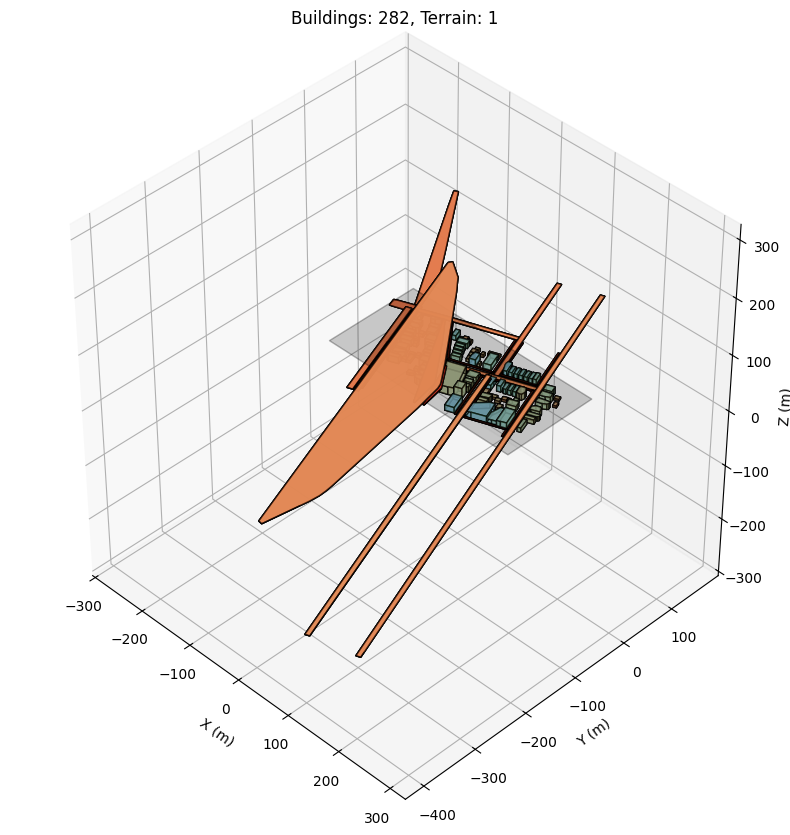

In [3]:
dataset.scene.plot()


In [4]:
dm.info()


Fundamental Matrices:
power: Tap power. Received power in dBW for each path, assuming 0 dBW transmitted power. 
10*log10(|a|²), where a is the complex channel amplitude
	[num_rx, num_paths]
phase: Tap phase. Phase of received signal for each path in degrees. 
∠a (angle of a), where a is the complex channel amplitude
	[num_rx, num_paths]
delay: Tap delay. Propagation delay for each path in seconds
	[num_rx, num_paths]
aoa_az: Angle of arrival (azimuth) for each path in degrees
	[num_rx, num_paths]
aoa_el: Angle of arrival (elevation) for each path in degrees
	[num_rx, num_paths]
aod_az: Angle of departure (azimuth) for each path in degrees
	[num_rx, num_paths]
aod_el: Angle of departure (elevation) for each path in degrees
	[num_rx, num_paths]
inter: Type of interactions along each path
	Codes: 0: LOS, 1: Reflection, 2: Diffraction, 3: Scattering, 4: Transmission
	Code meaning: 121 -> Tx-R-D-R-Rx
	[num_rx, num_paths]
inter_pos: 3D coordinates in meters of each interaction point along p

In [ ]:
[num_rx, num_rx_ant, num_tx_ant, X]
[(31719, 1, 8, 1)]

In [9]:
# dataset[0].los#["inter"].los
dataset[0]["channel"]

Generating channels: 100%|██████████| 31719/31719 [00:01<00:00, 28929.48it/s]


DeepMIMOArray([[[[0.+0.j],
                 [0.+0.j],
                 [0.+0.j],
                 ...,
                 [0.+0.j],
                 [0.+0.j],
                 [0.+0.j]]],


               [[[0.+0.j],
                 [0.+0.j],
                 [0.+0.j],
                 ...,
                 [0.+0.j],
                 [0.+0.j],
                 [0.+0.j]]],


               [[[0.+0.j],
                 [0.+0.j],
                 [0.+0.j],
                 ...,
                 [0.+0.j],
                 [0.+0.j],
                 [0.+0.j]]],


               ...,


               [[[0.+0.j],
                 [0.+0.j],
                 [0.+0.j],
                 ...,
                 [0.+0.j],
                 [0.+0.j],
                 [0.+0.j]]],


               [[[0.+0.j],
                 [0.+0.j],
                 [0.+0.j],
                 ...,
                 [0.+0.j],
                 [0.+0.j],
                 [0.+0.j]]],


               [[[0.+0.j],
           

In [120]:
config = {
    "BATCH_SIZE":64,
    "PAD_VALUE": 500,
    "USE_WANDB": False,
    "LR":2e-5,
    "epochs" : 100,
    "interaction_weight": 0.01,  # Weight for interaction loss
    # "experiment": "interacaction_power_only_dec_only",

    "experiment": "interacaction_delay_only_dec_only"
}




In [102]:
class MySeqDataLoader(torch.utils.data.Dataset):

    def __init__(self, scenario, tx_sets="all", seed=42, shuffle=False, pad_value=500, 
                 train=True, split_by="users", train_ratio=0.8, sort_by="power"):
        ### get length of dataset
        self.dataset = dm.load(scenario, tx_sets=tx_sets)
        self.Txs = 1
        self.pad_value = pad_value
        self.split_by = split_by
        self.sort_by = sort_by
        self.dataset_filtered = defaultdict(list)
        self.total_length = 0
        
        if type(self.dataset) == dict:
            self.dataset = [self.dataset]
        
        if split_by == "Tx":
            self.Txs = list(range(len(self.dataset)))
            if train:
                self.Txs = self.Txs[:int(train_ratio * len(self.Txs))]
            else:
                self.Txs = self.Txs[int(train_ratio * len(self.Txs)):]

            for tx in self.Txs:
                use_indices = self.dataset[tx].los != -1
                n_ue = self.dataset[tx].n_ue
            
                for k in self.dataset[tx]:
                    if k not in ["txrx", "load_params", "name", "rt_params", "materials", "scene", "n_ue"]:
                        if self.dataset[tx][k].shape[0] == n_ue:
                            self.dataset_filtered[k].extend(self.dataset[tx][k][use_indices].tolist())
                self.dataset_filtered["tx_pos"].extend(np.repeat(self.dataset[tx]["tx_pos"], n_ue, axis=0).tolist())

        elif split_by == "user":
            for tx in range(len(self.dataset)):
                n_ue = self.dataset[tx].n_ue

                # --- user-level splitting ---
                indices = np.arange(n_ue)
                np.random.seed(seed + tx)
                np.random.shuffle(indices)

                split_idx = int(train_ratio * len(indices))
                if train:
                    indices = indices[:split_idx]
                else:
                    indices = indices[split_idx:]

                use_indices = self.dataset[tx].los != -1
                indices = [i for i in indices if use_indices[i]]

                # Collect data
                for k in self.dataset[tx]:
                    if k in ["txrx", "load_params", "name", "rt_params", "materials", "scene", "n_ue"]:
                        continue
                    if self.dataset[tx][k].shape[0] == n_ue:
                        self.dataset_filtered[k].extend(self.dataset[tx][k][indices].tolist())

                # TX position duplicated for each UE sample
                self.dataset_filtered["tx_pos"].extend(
                    np.repeat(self.dataset[tx]["tx_pos"], len(indices), axis=0).tolist()
                )
        
        self.seed = seed
        self.total_length = len(self.dataset_filtered[list(self.dataset_filtered.keys())[0]])

        boundary = self.dataset[0]['rt_params']['raw_params']['studyarea']['boundary']['data']
        self.mins = np.array([boundary[0][0], boundary[0][1], 
                             self.dataset[0]['rt_params']['raw_params']['studyarea']['boundary']['values']['zmin']]).astype(np.float32)
        self.maxs = np.array([boundary[2][0], boundary[2][1], 
                             self.dataset[0]['rt_params']['raw_params']['studyarea']['boundary']['values']['zmax']]).astype(np.float32)

    def decode_interaction_to_multilabel(self, inter_code):
        """
        Convert interaction code to multi-label vector [R, D, S, T]
        Ignores repetitions: RRD -> RD, RR -> R
        
        Returns:
            np.array of shape (4,): binary indicators for [R, D, S, T]
            Returns [-1, -1, -1, -1] for invalid/NaN codes
        """
        if np.isnan(inter_code):
            return np.array([-1, -1, -1, -1], dtype=np.float32)
        
        code_str = str(int(inter_code))
        multi_label = np.zeros(4, dtype=np.float32)
        
        # Map: 1->R, 2->D, 3->S, 4->T
        for digit in code_str:
            if digit == '1':
                multi_label[0] = 1  # R
            elif digit == '2':
                multi_label[1] = 1  # D
            elif digit == '3':
                multi_label[2] = 1  # S
            elif digit == '4':
                multi_label[3] = 1  # T
        
        return multi_label

    def __getitem__(self, idx):
        prompt = []
        for k in ["tx_pos", "rx_pos"]:
            prompt.extend(self.dataset_filtered[k][idx])
        
        # Sort paths based on sort_by option
        if self.sort_by == "power":
            indices = np.argsort(-np.array(self.dataset_filtered["power"][idx]))
        elif self.sort_by == "delay":
            indices = np.argsort(np.array(self.dataset_filtered["delay"][idx]))
        else:
            raise ValueError(f"Unknown sort_by option: {self.sort_by}")

        paths = []
        interactions = []  # NEW: multi-label interactions
        valid_paths = 0
        
        # SOS token
        paths.append([0.0, 0.0, 0.0])
        interactions.append([-1, -1, -1, -1])  # SOS has no interaction label
        
        for step_idx, indx in enumerate(indices):
            output_per_step = []
            broken = False
            
            for k in ["delay", "power", "phase"]:
                value = self.dataset_filtered[k][idx][indx]
                if np.isnan(value):
                    value = self.pad_value
                    broken = True
                    break
                elif k == "delay":
                    value = value * 1e6  # convert to us
                elif k == "phase":
                    value = value * (np.pi/180)
                elif k == "power":
                    value = value * 0.01
                
                output_per_step.append(value)
            
            if not broken:
                valid_paths += 1
                paths.append(output_per_step)
                
                # NEW: Extract and decode interaction
                inter_value = self.dataset_filtered["inter"][idx][indx]
                inter_label = self.decode_interaction_to_multilabel(inter_value)
                interactions.append(inter_label)
        
        num_paths = [valid_paths]
        
        return (torch.tensor(prompt, dtype=torch.float32), 
                torch.tensor(paths, dtype=torch.float32), 
                torch.tensor(num_paths, dtype=torch.float32) / 25.0,
                torch.tensor(interactions, dtype=torch.float32))  # NEW

    def __len__(self):
        return self.total_length

    def collate_fn(self, batch):
        batch_prompts = torch.cat([i[0].unsqueeze(0) for i in batch], dim=0)
        batch_paths = [i[1] for i in batch]
        batch_paths = torch.nn.utils.rnn.pad_sequence(batch_paths, batch_first=True, 
                                                       padding_value=self.pad_value)
        batch_num_paths = [i[2] for i in batch]
        batch_num_paths = torch.nn.utils.rnn.pad_sequence(batch_num_paths, batch_first=True, 
                                                           padding_value=0)
        
        # NEW: collate interactions
        batch_interactions = [i[3] for i in batch]
        batch_interactions = torch.nn.utils.rnn.pad_sequence(batch_interactions, batch_first=True,
                                                             padding_value=-1)
        
        return batch_prompts, batch_paths, batch_num_paths, batch_interactions



In [ ]:
train_data  = MySeqDataLoader(scenario, train=True, split_by="user", sort_by="power")

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = True,
    collate_fn= train_data.collate_fn
    )
val_data  = MySeqDataLoader(scenario, train=False, split_by="user", sort_by="power")
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = False,
    collate_fn= val_data.collate_fn
    )

for item in train_loader:
    print(f"Prompt shape: {item[0].shape}, Paths shape: {item[1].shape}, Num paths shape: {item[2].shape} Interactions shape: {item[3].shape}")
    # print(np.round(item[1][0, :, 2] *(180/np.pi), decimals=2)[:5])
    
    break

In [ ]:
train_data  = MySeqDataLoader(scenario, train=True, split_by="user", sort_by="power")

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = True,
    collate_fn= train_data.collate_fn
    )
val_data  = MySeqDataLoader(scenario, train=False, split_by="user", sort_by="power")
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = False,
    collate_fn= val_data.collate_fn
    )

for item in train_loader:
    print(f"Prompt shape: {item[0].shape}, Paths shape: {item[1].shape}, Num paths shape: {item[2].shape}")
    
    break


def generate_paths(model, prompt, max_steps=25, stop_threshold=0.5):
    """
    Generate paths autoregressively.
    """
    model.eval()
    prompt = prompt.unsqueeze(0).cuda()  # (1, prompt_dim)

    # Start with SOS tokens
    cur = torch.zeros(1, 1, 3).cuda()  # (1, 1, 3) - delay, power, phase
    inter_str = -1 * torch.ones(1, 1, 4).cuda()  # (1, 1, 4) - interaction labels

    outputs = []
    outputs_inter_str = []
    
    for t in range(max_steps):
        # Forward pass
        d, p, s, c, ph, pathcounts, inter_str_logits = model(prompt, cur, inter_str)
        
        # Get last timestep predictions
        d_t = d[:, -1]           # (1,)
        p_t = p[:, -1]           # (1,)
        ph_t = ph[:, -1]         # (1,)
        inter_logits_t = inter_str_logits[:, -1]  # (1, 4)
        
        # **FIX: Convert logits to binary predictions**
        inter_pred_t = (torch.sigmoid(inter_logits_t) > 0.5).float()  # (1, 4) - binary [0, 1]
        
        # Store outputs
        outputs.append(torch.stack([d_t, p_t, ph_t], dim=-1))
        outputs_inter_str.append(inter_pred_t)
        
        # Append predictions for next iteration
        next_path = torch.stack([d_t, p_t, ph_t], dim=-1).unsqueeze(1)  # (1, 1, 3)
        cur = torch.cat([cur, next_path], dim=1)
        
        # **FIX: Use binary predictions, not logits**
        inter_str = torch.cat([inter_str, inter_pred_t.unsqueeze(1)], dim=1)  # (1, t+2, 4)

    return (torch.stack(outputs, dim=1).squeeze(0).detach().cpu(),  # (T, 3)
            pathcounts, 
            torch.stack(outputs_inter_str, dim=1).squeeze(0).detach().cpu())  # (T, 4)

In [ ]:
print("No. of Train Points   : ", train_data.__len__())
print("Batch Size           : ", config["BATCH_SIZE"])
print("Train Batches        : ", train_loader.__len__())
print("No. of Train Points   : ", val_data.__len__())
print("Val Batches          : ", val_loader.__len__())

In [26]:

class GPTBlock(nn.Module):
    def __init__(self, dim, n_heads, ff_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=dim, 
            num_heads=n_heads,
            dropout=0.1,
            batch_first=True
        )
        self.ln1 = nn.LayerNorm(dim)

        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.GELU(),
            nn.Linear(ff_dim, dim)
        )
        self.ln2 = nn.LayerNorm(dim)

    def forward(self, x, causal_mask):
        attn_out, _ = self.attn(x, x, x, attn_mask=causal_mask)
        x = x + attn_out
        x = self.ln1(x)

        ff_out = self.ff(x)
        x = x + ff_out
        x = self.ln2(x)

        return x


class GPTPathDecoder(nn.Module):
    def __init__(
        self,
        prompt_dim=6,
        hidden_dim=512,
        n_layers=6,
        n_heads=4,
        prefix_len=4,
        max_T=26,
        pad_value=500
    ):
        super().__init__()
        self.pad_value = pad_value
        self.hidden_dim = hidden_dim
        self.prefix_len = prefix_len
        self.max_T = max_T

        # Path token embedding
        self.path_in = nn.Linear(8, hidden_dim)

        self.pos_emb = nn.Embedding(max_T + prefix_len, hidden_dim)

        # Convert prompt → prefix tokens
        self.prompt_to_prefix = nn.Linear(prompt_dim, prefix_len * hidden_dim)

        # GPT layers
        self.layers = nn.ModuleList([
            GPTBlock(dim=hidden_dim, n_heads=n_heads, ff_dim=4 * hidden_dim)
            for _ in range(n_layers)
        ])

        # Output heads
        self.out = nn.Linear(hidden_dim, 4)  # delay, power, sin(phase), cos(phase)
        
        # NEW: Multi-label interaction head (4 outputs: R, D, S, T)
        self.interaction_head = nn.Linear(hidden_dim, 4)
        
        # Path count head
        self.pathcount_head = nn.Sequential(
            nn.Linear(prefix_len * hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, prompts, paths, interactions):
        """
        prompts: (B, prompt_dim)
        paths: (B, T, 4)
        interactions: (B,T,4)
        Returns:
            delay_pred, power_pred, phase_sin_pred, phase_cos_pred, 
            phase_pred, pathcounts, interaction_logits
        """
        B, T, _ = paths.shape

        phase = paths[:, :, 2]
        sinp = torch.sin(phase)
        cosp = torch.cos(phase)
        
        # Convert prompt → prefix tokens
        prefix_raw = self.prompt_to_prefix(prompts)
        prefix = prefix_raw.view(B, self.prefix_len, self.hidden_dim)

        # Embed path tokens
        paths_expanded = torch.stack([paths[:, :, 0], paths[:, :, 1], sinp, cosp], dim=-1)
        

        interactions_clean = interactions.clone()
        interactions_clean[interactions_clean == -1] = 0
    
        combined = torch.cat([paths_expanded, interactions_clean], dim=-1)
        x = self.path_in(combined)
        # Concatenate prefix + tokens
        full_seq = torch.cat([prefix, x], dim=1)

        # Positional embeddings
        pos = self.pos_emb(torch.arange(self.prefix_len + T, device=x.device))
        full_seq = full_seq + pos

        # Causal mask
        total_len = self.prefix_len + T
        causal_mask = torch.triu(
            torch.ones(total_len, total_len, device=x.device), 1
        ).bool()

        # Pass through GPT layers
        h = full_seq
        for layer in self.layers:
            h = layer(h, causal_mask)

        # Path predictions
        h_paths = h[:, self.prefix_len:, :]

        # Path parameters
        out = self.out(h_paths)
        delay_pred = out[:, :, 0]
        power_pred = out[:, :, 1]
        phase_sin_pred = out[:, :, 2]
        phase_cos_pred = out[:, :, 3]
        phase_pred = torch.atan2(phase_sin_pred, phase_cos_pred)
        
        # NEW: Interaction predictions (multi-label logits)
        interaction_logits = self.interaction_head(h_paths)  # (B, T, 4)
        
        # Path count head
        prefix_flat = prefix.reshape(B, -1)
        pathcounts = self.pathcount_head(prefix_flat)

        return (delay_pred, power_pred, phase_sin_pred, phase_cos_pred, 
                phase_pred, pathcounts, interaction_logits)

In [113]:



def masked_loss(delay_pred, power_pred, sin_pred, cos_pred, phase_pred, 
                path_length_predict, interaction_logits, targets, path_length_targets,
                interaction_targets, pad_value=500, interaction_weight=0.1):
    """
    Added interaction prediction loss as auxiliary task.
    
    Args:
        interaction_logits: (B, T, 4) - logits for [R, D, S, T]
        interaction_targets: (B, T, 4) - binary labels, -1 for invalid
        interaction_weight: weight for interaction loss
    """
    delay_t, power_t, phase_t = targets[:, :, 0], targets[:, :, 1], targets[:, :, 2]
    sinp = torch.sin(phase_t)
    cosp = torch.cos(phase_t)
    
    # Mask for valid paths
    mask = (delay_t != pad_value)

    # Existing losses
    loss_delay = ((delay_pred - delay_t)**2)[mask].mean()
    loss_power = ((power_pred - power_t)**2)[mask].mean()
    loss_sin = ((sin_pred - sinp)**2)[mask].mean()
    loss_cos = ((cos_pred - cosp)**2)[mask].mean()
    loss_phase = (loss_sin + loss_cos) / 2

    loss_path_length = ((path_length_targets - path_length_predict)**2).mean() * 0.0
    
    # NEW: Multi-label interaction loss
    # Mask: valid interactions (not -1)
    interaction_mask = (interaction_targets[:, :, 0] != -1)  # (B, T)
    
    if interaction_mask.any():
        # Binary cross-entropy for multi-label classification
        valid_logits = interaction_logits[interaction_mask]  # (N, 4)
        valid_targets = interaction_targets[interaction_mask]  # (N, 4)
        
        loss_interaction = F.binary_cross_entropy_with_logits(
            valid_logits,
            valid_targets,
            reduction='mean'
        )
    else:
        loss_interaction = torch.tensor(0.0, device=delay_pred.device)
    
    # total_loss = (loss_delay + loss_power + loss_phase + 
    #               loss_path_length + interaction_weight * loss_interaction)

    total_loss = (loss_power + 
                 + interaction_weight * loss_interaction)
     
    return (total_loss, loss_delay, loss_power, loss_phase, 
            loss_path_length, loss_interaction)

def compute_stop_metrics(path_count, targets, pad_value=500):
    """

    Args:

    """

    rmse = np.sqrt(mean_squared_error(path_count.cpu().numpy(), targets.squeeze().cpu().numpy()))
    
    return rmse 


from tqdm import tqdm
import torch
import numpy as np

def evaluate_model(model, val_loader, max_generate=26, log_to_wandb=False):
    model.eval()

    delay_errors = []
    power_errors = []
    phase_errors = []
    path_length_rmses = []



    delay_maes = []
    power_maes = []
    phase_maes = []
    path_length_maes = []
    with torch.no_grad():
        outer_bar = tqdm(val_loader, desc="Evaluating (batches)", leave=True)

        for prompts, paths, path_lengths,interactions in outer_bar:
            prompts = prompts.cuda()
            paths = paths.cuda()
            path_lengths = path_lengths.cuda()
         
            # Inner tqdm to show per-sample progress
            inner_bar = tqdm(range(prompts.size(0)), 
                             desc="   Processing samples", 
                             leave=False)

            for b in inner_bar:
                generated, path_lengths_pred, inter_str_pred = generate_paths(model, prompts[b], max_steps=max_generate)

                generated = generated.cuda()
                gt = paths[b][1:, :3]  # only (delay, power, phase)

                # Mask padded values
                valid_mask = (gt[:,0] != train_data.pad_value)
                gt = gt[valid_mask]

                T = min(len(gt), len(generated))
                pred = generated[:T]
                gt = gt[:T]

                # ---- Compute Metrics ----
                delay_rmse = torch.mean((pred[:,0] - gt[:,0])**2).sqrt().item()
                delay_mae = torch.mean(torch.abs(pred[:,0] - gt[:,0])).item()

                power_rmse = torch.mean((pred[:,1]/0.01 - gt[:,1]/0.01)**2).sqrt().item()
                power_mae = torch.mean((torch.abs(pred[:,1]/0.01 - gt[:,1]/0.01))).item()


                # Phase errors
                y_hat_angles = (pred[:,2] / (np.pi/180))
                y_angles = (gt[:,2] / (np.pi/180))
                # phase_rmse =    (torch.mean(y_hat_angles - y_angles)**2).sqrt().item()
                phase_circular_dist = (y_hat_angles - y_angles + 180) % 360 - 180
                phase_rmse = torch.mean(phase_circular_dist**2).sqrt().item()
                phase_mae = torch.mean(torch.abs(phase_circular_dist)).item()

                # Path length RMSE
                # print(path_lengths_pred, path_lengths[b],)
                length_rmse = (torch.mean( (path_lengths_pred - path_lengths[b])**2)).sqrt().item()
                length_mae = (torch.mean(torch.abs(path_lengths_pred - path_lengths[b]))).item()


                # Save metrics
                delay_errors.append(delay_rmse)
                power_errors.append(power_rmse)
                phase_errors.append(phase_rmse)
                path_length_rmses.append(length_rmse)

                delay_maes.append(delay_mae)
                power_maes.append(power_mae)
                phase_maes.append(phase_mae)
                path_length_maes.append(length_mae)
                # Show live metric values in tqdm
                inner_bar.set_postfix({
                    "delay": f"{delay_rmse:.3f}",
                    "power": f"{power_rmse:.3f}",
                    "phase": f"{phase_rmse:.3f}",
                    "length": f"{length_rmse:.3f}",
                    "delay": f"{delay_mae:.3f}",
                    "power": f"{power_mae:.3f}",
                    "phase": f"{phase_mae:.3f}",
                    "length": f"{length_mae:.3f}"
                })

                # wandb logging
                if log_to_wandb:
                    wandb.log({
                        "test_delay_rmse": delay_rmse,
                        "test_power_rmse": power_rmse,
                        "test_phase_circ_err": phase_rmse,
                        "test_stop_length_rmse": length_rmse,
                        "test_delay_mae": delay_mae,
                        "test_power_mae": power_mae,
                        "test_phase_circ_err_mae": phase_mae,
                        "test_stop_length_mae": length_mae,
                    })
            # print("Batch evaluation complete.")
            
            # print("\n================= Up toBATCH EVALUATION RESULTS =================")
            # print(f"Avg Delay RMSE           : {np.mean(delay_errors):.4f} µs")
            # print(f"Avg Power RMSE           : {np.mean(power_errors):.4f} dB")
            # print(f"Avg Phase RMSE           : {np.mean(phase_errors):.4f} degrees")
            # print(f"Avg Path Length RMSE     : {np.mean(path_length_rmses):.4f}")
            # print(f"Avg Delay MAE           : {np.mean(delay_maes):.4f} µs")
            # print(f"Avg Power MAE           : {np.mean(power_maes):.4f} dB")
            # print(f"Avg Phase MAE           : {np.mean(phase_maes):.4f} degrees")
            # print(f"Avg Path Length MAE     : {np.mean(path_length_maes):.4f}")
            # print("============================================================")
            

    # ---- Final Aggregated Results ----
    avg_delay = np.mean(delay_errors)
    avg_power = np.mean(power_errors)
    avg_phase = np.mean(phase_errors)
    avg_path_length_rmse = np.mean(path_length_rmses)
   
    avg_delay_mae = np.mean(delay_maes)
    avg_power_mae = np.mean(power_maes)
    avg_phase_mae = np.mean(phase_maes)
    avg_path_length_mae= np.mean(path_length_maes)

    print("\n=================  Final EVALUATION RESULTS =================")
    print(f"Delay RMSE           : {avg_delay:.4f} µs")
    print(f"Power RMSE           : {avg_power:.4f} dB")
    print(f"Phase RMSE           : {avg_phase:.4f} degrees")
    print(f"Path Length RMSE     : {avg_path_length_rmse:.4f}")
        
    print(f"Delay MAE           : {avg_delay_mae:.4f} µs")
    print(f"Power MAE           : {avg_power_mae:.4f} dB")
    print(f"Phase MAE           : {avg_phase_mae:.4f} degrees")
    print(f"Path Length MAE     : {avg_path_length_mae:.4f}")
    print("=====================================================\n")

    if log_to_wandb:
        wandb.run.summary["test_delay_rmse"] = avg_delay
        wandb.run.summary["test_power_rmse"] = avg_power
        wandb.run.summary["test_phase_circ_err"] = avg_phase
        wandb.run.summary["test_path_length_rmse"] = avg_path_length_rmse
        
        wandb.run.summary["test_delay_mae"] = avg_delay_mae
        wandb.run.summary["test_power_mae"] = avg_power_mae
        wandb.run.summary["test_phase_circ_err_mae"] = avg_phase_mae
        wandb.run.summary["test_path_length_mae"] = avg_path_length_mae

    return avg_delay, avg_power, avg_phase, avg_path_length_rmse, avg_delay_mae, avg_power_mae, avg_phase_mae,avg_path_length_mae 



def show_example(model, val_loader, sample_index=0, k=25, plot=True):
    model.eval()
    prompts, paths, path_lengths,interactions = next(iter(val_loader))
    
    prompts = prompts.cuda()
    paths = paths.cuda()
    
    pred_paths, path_lengths_pred,inter_str_pred= generate_paths(model, prompts[sample_index])
    print(f'pred_paths{pred_paths.shape}')

    pred = pred_paths  # (T,3)
    gt = paths[sample_index][1:, :3]  # Extract only 3D components (T,3)

    valid = (gt[:,0] != train_data.pad_value)
    gt = gt[valid]

    T = min(len(gt), len(pred))
    # print("len_path", len(pred), "actual = ", T)
    pred = pred[:T].cpu()
    gt = gt[:T].cpu()
    path_lengths_pred = path_lengths_pred.cpu()


    delay_rmse = torch.mean((pred[:,0] - gt[:,0])**2).sqrt().item()
    power_rmse = torch.mean((pred[:,1]/0.01 - gt[:,1]/0.01)**2).sqrt().item()
    # print(f"pred_delay{pred[:,0]}")
    # print(f"gt_delay{gt[:,0]}")

    # Phase errors
    y_hat_angles = (pred[:,2] / (np.pi/180))
    y_angles = (gt[:,2] / (np.pi/180))


    # phase_rmse =    (torch.mean(y_hat_angles - y_angles)**2).sqrt().item()
    phase_circular_dist = (y_hat_angles - y_angles + 180) % 360 - 180
    phase_rmse = torch.mean(phase_circular_dist**2).sqrt().item()
    phase_mae = torch.mean(torch.abs(phase_circular_dist)).item()

    length_rmse = (torch.mean( (path_lengths_pred - path_lengths[sample_index])**2)).sqrt().item()


    print({
            "delay": f"{delay_rmse:.3f}",
            "power": f"{power_rmse:.3f}",
            "phase_rmse": f"{phase_rmse:.3f}",
            "phase_mae": f"{phase_mae:.3f}",
            "length": f"{length_rmse:.3f}"
                })

    # print("\n--- Ground Truth Length {} ".format(len(gt)))

    # print("\n--- Model Predict Length (first {} paths) ---".format(path_lengths_pred.item()))
    
    
    # print(gt[:k])
    # print(pred[:k])

    if plot:
        # T = min(len(gt), len(pred))
        # # print("len_path", len(pred), "actual = ", T)
        # pred = pred[:T]
        # gt = gt[:T]

        fig, axs = plt.subplots(3,1, figsize=(10,12))

        axs[0].plot(gt[:,0], label="GT Delay", marker='o')
        axs[0].plot(pred[:,0], label="Pred Delay", marker='x')
        axs[0].set_title("Path Delay (µs)")
        axs[0].legend()

        axs[1].plot(gt[:,1]*0.01, label="GT Power", marker='o')
        axs[1].plot(pred[:,1]*0.01, label="Pred Power", marker='x')
        axs[1].set_title("Path Power dB")
        axs[1].legend()

        axs[2].plot(gt[:,2]/(np.pi/180), label="GT Phase", marker='o')
        axs[2].plot(pred[:,2]/(np.pi/180), label="Pred Phase", marker='x')
        axs[2].set_title("Path Phase (degrees)")

        axs[2].legend()

        plt.tight_layout()
        plt.show()


def evaluate_generation(val_loader, n_samples=3):
    model.eval()
    for i, (prompts, paths) in enumerate(val_loader):
        if i >= n_samples:
            break
        pred, path_lengths_pred = generate_paths(model, prompts[0])  # autoregressive generation
        print(f"path lengths pred: {path_lengths_pred[0]}")
        print(f"\nSample {i}")
        print("GT paths (first 5):")
        print(paths[0][:5])
        print("Predicted paths (first 5):")
        print(pred[0][:5])

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = PathDecoder().to(device)
model = GPTPathDecoder().to(device)

print("Total trainable parameters:", count_parameters(model))


In [ ]:
if config["USE_WANDB"]:
    import wandb

    wandb.init(
        project="deepmimo-path-decoder",
        config={
            "batch_size": train_loader.batch_size,
            "split_type": train_data.split_by,
        }
    )


In [122]:


optimizer = torch.optim.AdamW(model.parameters(), lr=config["LR"])
# scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, mode="min")
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=20,      # Restart every 10 epochs
    T_mult=2,    # Double the period after each restart
    eta_min=1e-8 # Minimum LR
)

# Initialize best checkpoint tracking (based on path_length loss)

# scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, mode="min")

checkpoint_path = f"{config['experiment']}_best_model_checkpoint.pth"
os.makedirs("checkpoints2", exist_ok=True)
checkpoint_path = os.path.join("checkpoints2", checkpoint_path)
def train_with_interactions(model, train_loader, val_loader, config, train_data):
    """
    Modified training loop with interaction prediction.
    """

    best_val_loss = float('inf')


    for epoch in range(config["epochs"]):
        # -------------------- TRAINING --------------------
        model.train()
        train_losses = []
        train_loss_delay = []
        train_loss_power = []
        train_loss_phase = []
        train_loss_path_length = []
        train_loss_interaction = []  # NEW
        train_path_length_rmse = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
        for prompts, paths, path_lengths, interactions in pbar:  # NEW: added interactions
            prompts = prompts.cuda()
            paths = paths.cuda()
            path_lengths = path_lengths.cuda()
            interactions = interactions.cuda()  # NEW
            
            paths_in = paths[:, :-1, :]
            interactions_in = interactions[:, :-1, :]

            paths_out = paths[:, 1:, :]
            interactions_out = interactions[:, 1:, :]  # NEW: shift targets

            (delay_pred, power_pred, sin_pred, cos_pred, phase_pred, 
             path_length_pred, interaction_logits) = model(prompts, paths_in, interactions_in)
            
            (total_loss, loss_delay, loss_power, loss_phase, 
             loss_path_length, loss_interaction) = masked_loss(
                delay_pred, power_pred, sin_pred, cos_pred, phase_pred, 
                path_length_pred, interaction_logits, paths_out, path_lengths,
                interactions_out, pad_value=train_data.pad_value,
                interaction_weight=config.get("interaction_weight", 0.1)
            )

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            scheduler.step()
            path_length_rmse = compute_stop_metrics(path_length_pred.detach().squeeze(-1), 
                                                    path_lengths)

            train_losses.append(total_loss.item())
            train_loss_delay.append(loss_delay.item())
            train_loss_power.append(loss_power.item())
            train_loss_phase.append(loss_phase.item())
            train_loss_path_length.append(loss_path_length.item())
            train_loss_interaction.append(loss_interaction.item())  # NEW
            train_path_length_rmse.append(path_length_rmse)
            current_lr = optimizer.param_groups[0]["lr"]
            pbar.set_postfix({
                "loss": f"{total_loss.item():.4f}",
                "delay": f"{loss_delay.item():.4f}",
                "power": f"{loss_power.item():.4f}",
                "phase": f"{loss_phase.item():.4f}",
                "inter": f"{loss_interaction.item():.4f}",  # NEW
                "path_rmse": f"{path_length_rmse:.4f}",
                "lr": f"{current_lr:.2e}"
            })

        avg_train_loss = np.mean(train_losses)
        avg_train_delay = np.mean(train_loss_delay)
        avg_train_power = np.mean(train_loss_power)
        avg_train_phase = np.mean(train_loss_phase)
        avg_train_path_length = np.mean(train_loss_path_length)
        avg_train_interaction = np.mean(train_loss_interaction)  # NEW
        avg_train_path_length_rmse = np.mean(train_path_length_rmse)

        # -------------------- VALIDATION --------------------
        model.eval()
        val_losses = []
        val_loss_delay = []
        val_loss_power = []
        val_loss_phase = []
        val_loss_path_length = []
        val_loss_interaction = []  # NEW
        val_path_length_rmse = []

        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
            for prompts, paths, path_lengths, interactions in pbar:  # NEW
                prompts = prompts.cuda()
                paths = paths.cuda()
                path_lengths = path_lengths.cuda()
                interactions = interactions.cuda()  # NEW
                
                paths_in = paths[:, :-1, :]
                interactions_in = interactions[:, :-1, :]

                paths_out = paths[:, 1:, :]
                interactions_out = interactions[:, 1:, :]  # NEW: shift targets

                (delay_pred, power_pred, sin_pred, cos_pred, phase_pred, 
                 path_length_pred, interaction_logits) = model(prompts, paths_in,interactions_in)
                
                (total_loss, loss_delay, loss_power, loss_phase, 
                 loss_path_length, loss_interaction) = masked_loss(
                    delay_pred, power_pred, sin_pred, cos_pred, phase_pred, 
                    path_length_pred, interaction_logits, paths_out, path_lengths,
                    interactions_out, pad_value=train_data.pad_value,
                    interaction_weight=config.get("interaction_weight", 0.1)
                )

                path_length_rmse = compute_stop_metrics(path_length_pred.detach().squeeze(-1), 
                                                       path_lengths)

                val_losses.append(total_loss.item())
                val_loss_delay.append(loss_delay.item())
                val_loss_power.append(loss_power.item())
                val_loss_phase.append(loss_phase.item())
                val_loss_path_length.append(loss_path_length.item())
                val_loss_interaction.append(loss_interaction.item())  # NEW
                val_path_length_rmse.append(path_length_rmse)
               
                pbar.set_postfix({
                    "val_loss": f"{total_loss.item():.4f}",
                    "inter": f"{loss_interaction.item():.4f}",  # NEW
                    
                })

        avg_val_loss = np.mean(val_losses)
        avg_val_delay = np.mean(val_loss_delay)
        avg_val_power = np.mean(val_loss_power)
        avg_val_phase = np.mean(val_loss_phase)
        avg_val_path_length = np.mean(val_loss_path_length)
        avg_val_interaction = np.mean(val_loss_interaction)  # NEW
        avg_val_path_length_rmse = np.mean(val_path_length_rmse)

        # scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]["lr"]

        # -------------------- CHECKPOINT SAVING --------------------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': torch.tensor(best_val_loss),
            }, checkpoint_path)
            print(f"  ✓ Best checkpoint saved (val_loss: {best_val_loss:.4f})")

        if config.get("USE_WANDB", False):
            import wandb
            wandb.log({
                "train_loss": avg_train_loss,
                "train_loss_delay": avg_train_delay,
                "train_loss_power": avg_train_power,
                "train_loss_phase": avg_train_phase,
                "train_loss_path_length": avg_train_path_length,
                "train_loss_interaction": avg_train_interaction,  # NEW
                "train_path_length_rmse": avg_train_path_length_rmse,
                "val_loss": avg_val_loss,
                "val_loss_delay": avg_val_delay,
                "val_loss_power": avg_val_power,
                "val_loss_phase": avg_val_phase,
                "val_loss_path_length": avg_val_path_length,
                "val_loss_interaction": avg_val_interaction,  # NEW
                "val_path_length_rmse": avg_val_path_length_rmse,
                "epoch": epoch,
                "lr": current_lr,
            })

        print(f"\nEpoch {epoch:02d}")
        print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"    Delay: {avg_train_delay:.4f} (val: {avg_val_delay:.4f})")
        print(f"    Power: {avg_train_power:.4f} (val: {avg_val_power:.4f})")
        print(f"    Phase: {avg_train_phase:.4f} (val: {avg_val_phase:.4f})")
        print(f"    Interaction: {avg_train_interaction:.4f} (val: {avg_val_interaction:.4f})")  # NEW
        print(f"  LR: {current_lr:.3e}")


In [121]:




# Train
train_with_interactions(model, train_loader, val_loader, config, train_data)

KeyboardInterrupt: 


evaluate_generation(train_loader)


In [123]:
def load_best_checkpoint(model, checkpoint_path="checkpoints2/best_model_checkpoint.pth"):
    """
    Load the best model checkpoint saved during training.
    
    Args:
        model: The model instance to load the checkpoint into
        checkpoint_path: Path to the checkpoint file
    
    Returns:
        epoch: Epoch at which best checkpoint was saved
        best_val_loss: Best validation loss achieved
    """
    if not os.path.exists(checkpoint_path):
        print(f"Warning: Checkpoint not found at {checkpoint_path}")
        return None, None
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    best_avg_val_loss = checkpoint['best_val_loss']
    
    print(f"✓ Loaded best checkpoint from epoch {epoch} (val_loss: {best_avg_val_loss:.4f})")
    return epoch, best_avg_val_loss
# torch.serialization.add_safe_globals([np._core.multiarray.scalar])
# torch.serialization.add_safe_globals([np.dtype])

# Load best checkpoint for inference/evaluation
best_epoch, best_loss = load_best_checkpoint(model, checkpoint_path=checkpoint_path)

✓ Loaded best checkpoint from epoch 99 (val_loss: 0.0054)


In [118]:
checkpoint_path

'checkpoints2/interacaction_power_only_dec_only_best_model_checkpoint.pth'

In [124]:
evaluate_model(model, val_loader)


Evaluating (batches): 100%|██████████| 152/152 [12:58<00:00,  5.12s/it]


=================  Final EVALUATION RESULTS =================
Delay RMSE           : 0.0829 µs
Power RMSE           : 68.9640 dB
Phase RMSE           : 102.1296 degrees
Path Length RMSE     : 5.4227
Delay MAE           : 0.0611 µs
Power MAE           : 67.9813 dB
Phase MAE           : 90.2244 degrees
Path Length MAE     : 5.4227



(np.float64(0.08294526921203323),
 np.float64(68.9639556069713),
 np.float64(102.12960538132276),
 np.float64(5.422748308199973),
 np.float64(0.06105345120722873),
 np.float64(67.98133317488062),
 np.float64(90.22438313776838),
 np.float64(5.422748308199973))

In [108]:
for i in range(32):
    show_example(model, val_loader, sample_index=i, plot = False)





pred_pathstorch.Size([25, 3])
{'delay': '0.998', 'power': '193.996', 'phase_rmse': '86.921', 'phase_mae': '75.136', 'length': '5.229'}
pred_pathstorch.Size([25, 3])
{'delay': '0.796', 'power': '186.492', 'phase_rmse': '120.406', 'phase_mae': '108.716', 'length': '1.839'}
pred_pathstorch.Size([25, 3])
{'delay': '0.720', 'power': '187.567', 'phase_rmse': '117.072', 'phase_mae': '103.475', 'length': '3.706'}
pred_pathstorch.Size([25, 3])
{'delay': '1.185', 'power': '193.881', 'phase_rmse': '65.053', 'phase_mae': '55.058', 'length': '9.571'}
pred_pathstorch.Size([25, 3])
{'delay': '0.775', 'power': '171.919', 'phase_rmse': '118.151', 'phase_mae': '104.181', 'length': '2.029'}
pred_pathstorch.Size([25, 3])
{'delay': '0.766', 'power': '166.265', 'phase_rmse': '98.754', 'phase_mae': '85.830', 'length': '1.798'}
pred_pathstorch.Size([25, 3])
{'delay': '1.038', 'power': '195.587', 'phase_rmse': '122.254', 'phase_mae': '122.254', 'length': '7.443'}
pred_pathstorch.Size([25, 3])
{'delay': '0.682'

pred_pathstorch.Size([25, 3])
{'delay': '0.619', 'power': '154.309', 'phase': '97.317', 'length': '2.640'}


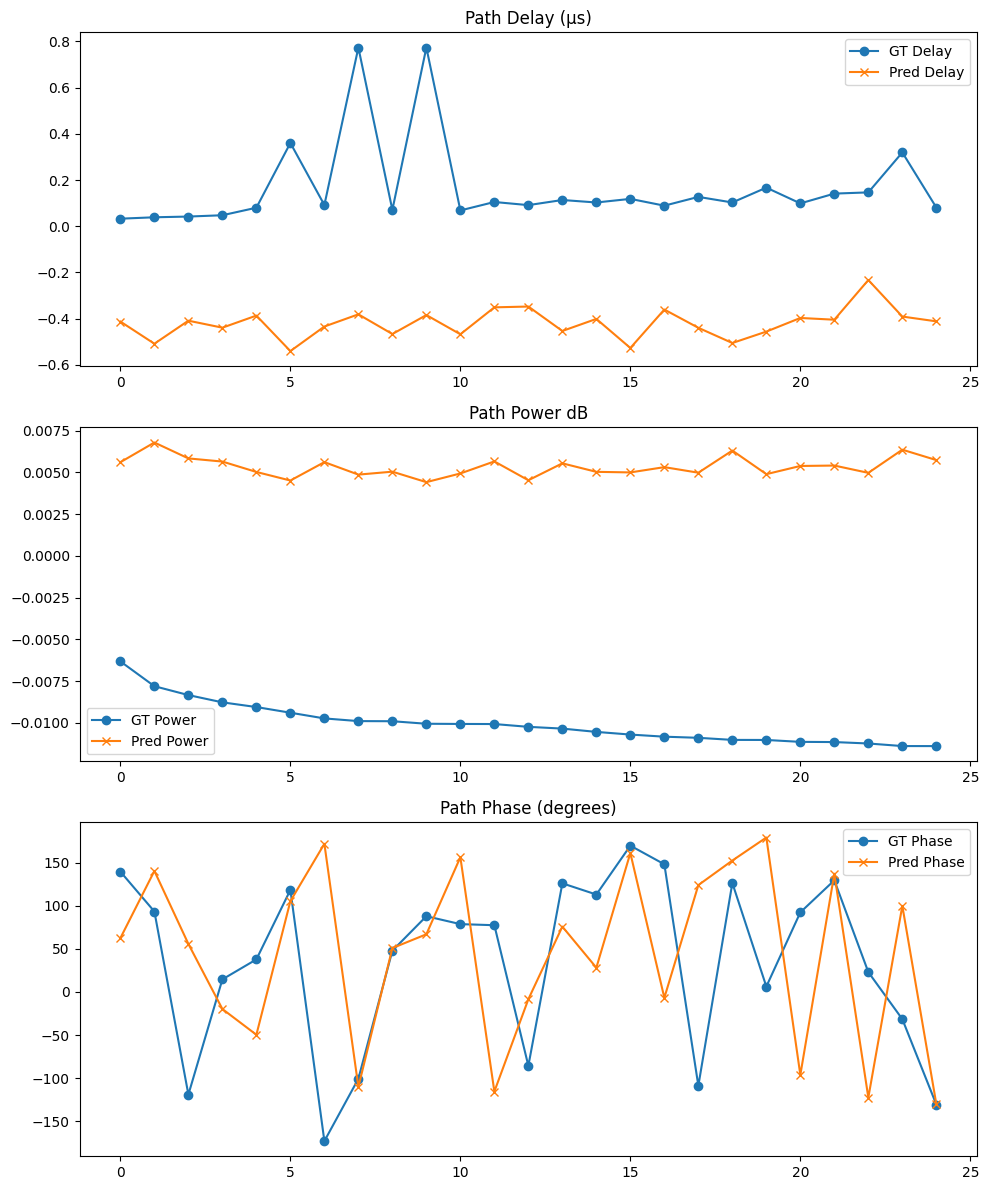

In [105]:
show_example(model, val_loader, sample_index=10, plot = True)

In [76]:
pred = np.array([0.0088, 0.0243, 0.0304, 0.0334, 0.0862, 0.2551, 0.0711, 0.4999, 0.1661,
        0.0688, 0.2041, 0.1403, 0.2903, 0.1347, 0.0920, 0.0841, 0.0854, 0.1382,
        0.1167, 0.1135, 0.1461, 0.0750, 0.1404, 0.1164, 0.1168])
gt = np.array([0.0327, 0.0388, 0.0419, 0.0476, 0.0802, 0.3602, 0.0918, 0.7728, 0.0707,
        0.7731, 0.0684, 0.1049, 0.0914, 0.1135, 0.1028, 0.1184, 0.0890, 0.1270,
        0.1028, 0.1670, 0.0989, 0.1412, 0.1465, 0.3193, 0.0810])

print(np.sqrt(np.mean ( (pred-gt)**2))), print(np.mean(np.abs( pred-gt)))

0.16798842102954598
0.085808


(None, None)

In [ ]:
offset = np.pi -1
np.sin(1.7 + offset), np.sin(1.7- offset)